# Detecting electrode inversion in an ECG


The ECG is a time series that measures the electrical activity of the heart. This is the main tool to diagnose heart diseases. Recording an ECG is simple: 3 electrodes are placed at the ends of limbs, and 6 on the anterior chest.This generates **12 time series**, called leads, each corresponding to a difference in potential between a pair of electrodes.

The electrodes' position is very important to correctly interpret the ECG. Making the mistake of inverting electrodes compromises interpretation, either because the leads do not explore the expected area (errors in the measures of hypertrophia indices, in the analysis of the ST segment), or because they generate false abnormalities (fake Q waves, error in the heart's axis...).

Inversion errors are frequent (5% of ECGs), and only experts (cardiologists) manage to detect them. But most ECGs are not interpreted by experts: only 30% are, the rest being interpreted by nurses or general practitioners. An algorithm for automatic detection of electrode inversion is therefore paramount to the correct interpretation of ECGs  and would improve the quality of diagnosis.

This project is intended to make you detect electrode inversion in an ECG. The dataset at your disposal contains ECGs from a cardiology center. **An ECG will be labeled as correctly realised (0) or as inverted (1).**
The goal is to perform **binary classification** on these ECGs.

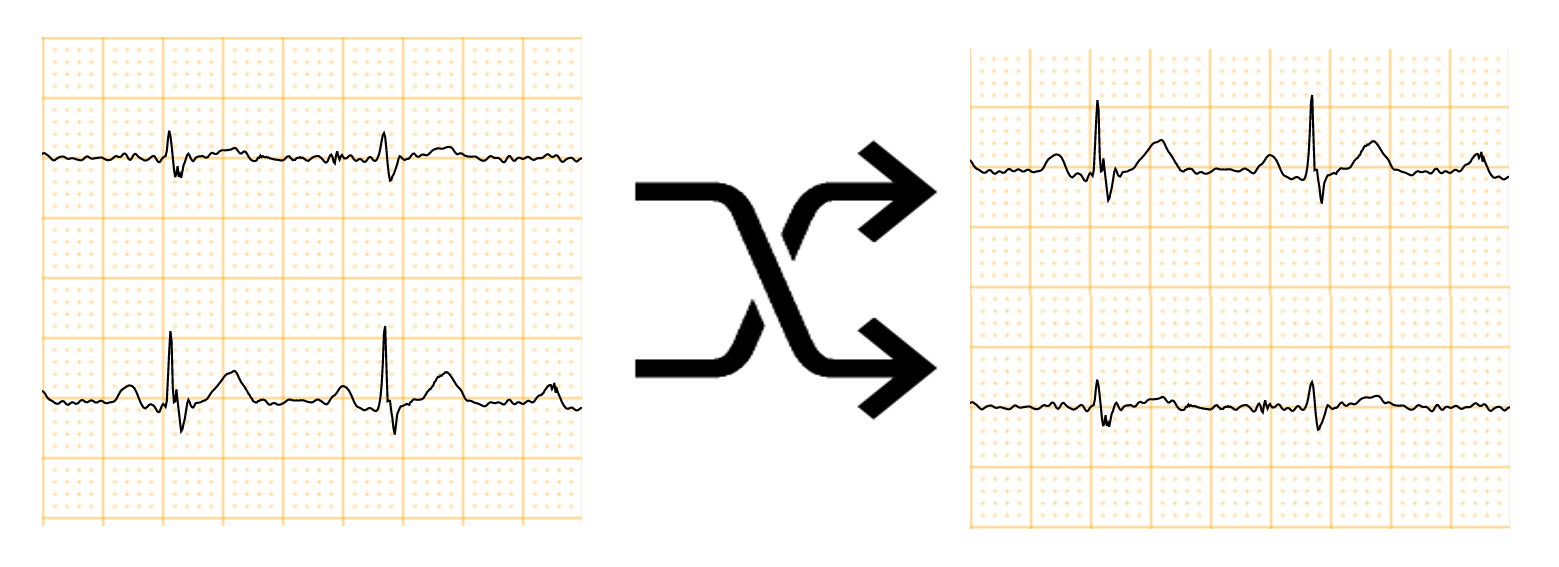

## Inversions

Inversions do not necessarily correspond to the inversion of only 2 leads:
* Precordial leads from (V1, ..., V6) can be inverted: V1 becomes V6, V2 becomes V5...
* 2 electrodes can be exchanged, which modifies several leads from ML1, ML2, ML3, AVF, AVR, AVL. For instance, if electrodes of the right and left arms are inverted, then ML1 becomes -ML1, ML2 and ML3 are inverted, AVL and AVR are inverted and AVF remains the same. More details here: https://litfl.com/ecg-limb-lead-reversal-ecg-library/


## Data

The training data contains 1400 ECGs and their labels. For each ECG, the data consists of **10 seconds** of recording for **12 leads**, each sampled at **250Hz**.

The testing data contains 2630 ECGs on which you will give your predictions at the end of the homework in a numpy array with a shape (2630,).

Each input file therefore contains the ECG signal in the form **(n_ecgs, n_samples=2500, n_leads=12)**.



## Objective

The key objective is to propose a **deep learning model** relevant to the task that shows good accuracy in detection of lead inversion.

## 1. Load and analyze the data

In [8]:
import numpy as np
import pandas as pd
import os
import sys
import plotly.express as px
import matplotlib.pyplot as plt
dirname = os.getcwd()
data_path = os.path.join(dirname,'candidate_files')
x_train = np.load(os.path.join(data_path,'input_training.npy'))
y_train = np.load(os.path.join(data_path,'output_training.npy'))
x_test = np.load(os.path.join(data_path,'input_test_set.npy'))


In [2]:
print(x_train.shape,x_train.dtype)
print(y_train.shape,y_train.dtype)
print(x_test.shape,y_train.dtype)

(1400, 12, 2500) float64
(1400,) float64
(2630, 12, 2500) float64


As announced in the statement, we have **1400 ECGs** with **12 leads**, each with 250 measurements per second, totaling **2500 measurements** for 10 seconds in the training set (x_train). <br>
We have **1400 labels**, where a value of 0 indicates correctly recorded ECGs, and 1 indicates inverted ECGs (y_train).<br>
Finally, we have **2630 ECGs** for testing, presented in the same format as the ECGs in the training set (x_test).

In [3]:
#Type Correction
y_train = y_train.astype('int64')

In [4]:
correct_ecg_proportion = np.bincount(y_train)
data = {
    'Value' : ['Correct ECG','Inverted ECG'],
    'Number' : correct_ecg_proportion
}

In [5]:


n = len(y_train)
fig = px.pie(data,names='Value', values='Number', title='Proportion of inverted ECG in the training Dataset')
fig.show()


We have an equal distribution of 50% for each case. This will make training easier, as the model will not be biased by an imbalanced dataset.

In [6]:
df_y = pd.DataFrame(y_train,columns=['is_correct'])
index_correct_ecg = df_y[df_y['is_correct']==0].index
index_inverted_ecg = df_y.drop(index_correct_ecg).index

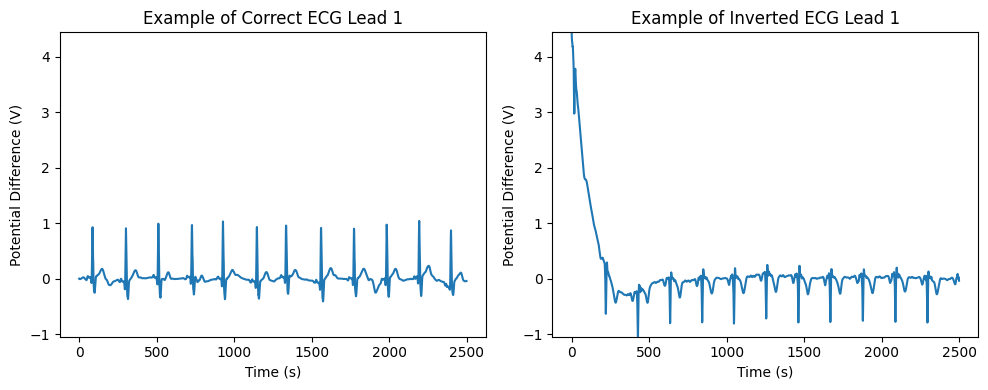

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
x1 = x_train[index_correct_ecg[0]][3]
x2 = x_train[index_inverted_ecg[0]][3]
y_min = min(np.min(x1), np.min(x2))
y_max = max(np.max(x1), np.max(x2))

# X1 settings
ax1.plot(x1)
ax1.set_title('Example of Correct ECG Lead 1')
ax1.set_ylim(y_min, y_max)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Potential Difference (mV)')
# X2 settings
ax2.plot(x2)
ax2.set_title('Example of Inverted ECG Lead 1')
ax2.set_ylim(y_min, y_max)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Potential Difference (V)')
#Plot
plt.tight_layout()
plt.show()

We observe a difference in the range of taken data; indeed, the correct ECG takes much higher values than the inverted one over the 10 seconds. This is a good information because during the training, if we take for a example the maximum for each lead ( with a Pooling layer for example ) it will for sure help the model to converge.

In [ ]:
d = {}
d['min'] = {}
d['min_good_ecg'] = {}
d['min_bad_ecg'] = {}
d['max'] = {}
d['max_good_ecg'] = {}
d['max_bad_ecg'] = {}
d['mean'] = {}
d['mean_good_ecg'] = {}
d['mean_bad_ecg'] = {}
d['std'] = {}
d['std_good_ecg'] = {}
d['std_bad_ecg'] = {}
for i in range(12):
    lead = 'Lead_{}'.format(i+1)
    d['min'][lead] = x_train[:,i,:].min()
    d['min_good_ecg'][lead] =  x_train[index_correct_ecg,i,:].min()
    d['min_bad_ecg'][lead] = x_train[index_inverted_ecg,i,:].min()
    d['max'][lead] = x_train[:,i,:].max()
    d['max_good_ecg'][lead] =  x_train[index_correct_ecg,i,:].max()
    d['max_bad_ecg'][lead] = x_train[index_inverted_ecg,i,:].max()
    d['mean'][lead] = x_train[:,i,:].mean()
    d['mean_good_ecg'][lead] =  x_train[index_correct_ecg,i,:].mean()
    d['mean_bad_ecg'][lead] = x_train[index_inverted_ecg,i,:].mean()
    d['std'][lead] = x_train[:,i,:].std()
    d['std_good_ecg'][lead] =  x_train[index_correct_ecg,i,:].std()
    d['std_bad_ecg'][lead] = x_train[index_inverted_ecg,i,:].std()

In [ ]:
df = pd.DataFrame(d)
df

,min,min_good_ecg,min_bad_ecg,max,max_good_ecg,max_bad_ecg,mean,mean_good_ecg,mean_bad_ecg,std,std_good_ecg,std_bad_ecg
Lead_1,-31.00000,-8.97880,-31.00000,31.00000,16.68525,31.0,0.014880,0.024337,0.005370,0.315369,0.330904,0.298630
Lead_2,-31.00004,-11.34687,-31.00004,31.00000,31.00000,31.0,0.010851,0.016054,0.005619,0.281737,0.264431,0.298040
Lead_3,-31.00000,-16.63614,-31.00000,31.00000,31.00000,31.0,-0.004408,-0.009481,0.000694,0.310344,0.348491,0.266431
Lead_4,-31.00000,-22.74244,-31.00000,31.00000,16.66716,31.0,0.009485,0.016789,0.002140,0.290436,0.321042,0.255781
Lead_5,-22.75221,-22.75221,-22.72552,31.00000,10.17338,31.0,-0.013141,-0.020572,-0.005667,0.267503,0.253751,0.280456
Lead_6,-22.83145,-8.36011,-22.83145,31.00000,31.00000,31.0,0.002964,0.003036,0.002892,0.261025,0.261379,0.260668
Lead_7,-26.81377,-26.81377,-18.22021,31.00000,31.00000,31.0,-0.017314,-0.022922,-0.011674,0.419739,0.416700,0.422698
Lead_8,-17.03447,-16.07535,-17.03447,31.00000,31.00000,31.0,-0.001870,-0.006779,0.003066,0.507170,0.521620,0.492160
Lead_9,-31.00000,-31.00000,-27.37870,31.00000,31.00000,31.0,0.009345,0.005862,0.012848,0.636677,0.697024,0.569549
Lead_10,-31.00616,-31.00616,-7.51846,31.00000,31.00000,31.0,0.023836,0.024956,0.022710,0.601423,0.729530,0.436147


An important difference in potential difference values can already be observed. For instance, for lead 1, in the case of correct ECGs, the values range from -9 to 17, whereas we have a broader spectrum for inverted ECGs. This pattern is also observed in most leads.

## 2. Classification using the raw signal
The goal here is to perform classification using directly the raw data.

### Which variant of neural networks would be more adequate for the task? (RNN, CNN, DNN...)

<br>
We need to first define what we are trying to achieve: <br>
<br>
We are looking to identify inverted ECGs <=> Detect abnormal patterns in arrays of size (12,2500).<br>

- **FNN/DNN** : Not really relevant since the spatial structure is important here: We know that the ECG is inverted by analyzing all the leads.We will have to flat arrays at the beginning and maybe lost informations.<br>
It's a relatively simple task, so using a DNN seems a bit excessive and could lead to overfitting, especially with only 1400 samples.<br>

- **RNN** : We analyze the data over 10 seconds, and these 10 seconds are not the same for each patient. It seems challenging here to detect patterns related to time and incorporate the temporal dimension into training.<br>

Therefore, my preference leans towards Convolutional Neural Networks (CNNs). While CNNs are commonly used for image processing, our data doesn't consist of images. However, the structure of our data shares similarities with images. Indeed, in our case the spatial structure is important and the CNN model is able to detect local pattern. Also,it can recognize patterns regardless of their position in the input contrary to RNN.


### b) Training & Evaluation

In [ ]:
mean = np.mean(x_train,axis = 0,keepdims=True)
std = np.std(x_train, axis=0, keepdims=True)

normalized_data = (x_train-mean) / std

In [ ]:
x_train.shape

(1400, 12, 2500)

In [ ]:
mean.shape

(1, 12, 2500)

In [ ]:
import keras
from keras import layers, models

In [93]:
model2 = models.Sequential([
    layers.Conv1D(32, kernel_size=25, activation='relu', input_shape=(2500,12)),
    layers.Conv1D(64, kernel_size=25, activation='relu'),
    layers.GlobalMaxPooling1D(), #Take the maximum for each lead => help to spot the inverted*
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid') #Sigmoid activation function
   
])

# Compilation
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display summary
model2.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_50 (Conv1D)          (None, 2476, 32)          9632      
                                                                 
 conv1d_51 (Conv1D)          (None, 2452, 64)          51264     
                                                                 
 global_max_pooling1d_18 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_71 (Dense)            (None, 32)                2080      
                                                                 
 dense_72 (Dense)            (None, 16)                528       
                                                     

In [94]:

# model traning
model2.fit(np.transpose(x_train,(0,2,1)), y_train, epochs=10, batch_size=16, validation_split=0.1)


Epoch 1/10
79/79 [==============================] - 28s 305ms/step - loss: 0.6769 - accuracy: 0.6341 - val_loss: 0.6235 - val_accuracy: 0.7000
Epoch 2/10
79/79 [==============================] - 20s 250ms/step - loss: 0.6012 - accuracy: 0.7056 - val_loss: 0.5126 - val_accuracy: 0.7786
Epoch 3/10
79/79 [==============================] - 20s 258ms/step - loss: 0.4221 - accuracy: 0.8310 - val_loss: 0.5176 - val_accuracy: 0.8071
Epoch 4/10
79/79 [==============================] - 22s 273ms/step - loss: 0.3429 - accuracy: 0.8611 - val_loss: 0.3134 - val_accuracy: 0.8357
Epoch 5/10
79/79 [==============================] - 21s 272ms/step - loss: 0.3255 - accuracy: 0.8730 - val_loss: 0.3520 - val_accuracy: 0.8714
Epoch 6/10
79/79 [==============================] - 20s 253ms/step - loss: 0.2570 - accuracy: 0.9087 - val_loss: 0.4699 - val_accuracy: 0.8357
Epoch 7/10
79/79 [==============================] - 24s 306ms/step - loss: 0.2600 - accuracy: 0.9000 - val_loss: 0.4522 - val_accuracy: 0.8500

In [46]:
np.transpose(x_train,(0,2,1)).shape

(1400, 2500, 12)

### c) What would you explore to improve your results?

Try to play with the hyperparameters (learning rate, number of convolutional layers,batch size, number of epochs...)
Try to increase the numbers of data, for image classification we can

## 3. Prediction on the test set
Use the output model of section 2 to make predictions on the testing set.

**Save your predictions in a file predictions.npy that you will send along with your notebook.**

The expected format is a binary array of shape (n_ecgs=2630,) where each value corresponds to the prediction on the corresponding ECG of the test set.